<a href="https://colab.research.google.com/github/sohitkumar7505/movie_review/blob/main/moviereview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# load dataset - we already have df
df = pd.read_csv("/content/imb.csv",delimiter=",")
df = df[['review', 'sentiment']]  # keep only required columns

# map sentiment to numerical labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to HF dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:

test_dataset = test_dataset.rename_column("label", "labels")
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['review', 'sentiment', 'labels', '__index_level_0__'],
    num_rows: 10000
})
Dataset({
    features: ['review', 'sentiment', 'labels', '__index_level_0__'],
    num_rows: 10000
})


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["review"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# ✅ Only set format, do NOT rename again
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
!pip install -U "transformers>=4.40.0"
# then restart the runtime: Runtime → Restart session



In [ ]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./distilbert-output",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=50,
    fp16=True,
    do_eval=True,
    save_steps=500,
    eval_steps=500,
    # legacy-friendly: no evaluation_strategy/save_strategy/load_best_model_at_end
    # (you can still call trainer.evaluate() after training)
)


In [ ]:
import transformers, inspect
print(transformers.__version__)
print(inspect.signature(transformers.TrainingArguments))


4.57.1
(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str] = <factory>, warmup_ratio: float = 0.0, warmup_steps: int =

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer

# Load model (DistilBERT with classification head)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sohitkumar3139 (sohitkumar3139-nit-jalandhar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.540700
100,0.362900
150,0.440200
200,0.366900
250,0.368100
300,0.407800
350,0.387700
400,0.342700
450,0.365200
500,0.321000


TrainOutput(global_step=2500, training_loss=0.2526472311019897, metrics={'train_runtime': 336.8141, 'train_samples_per_second': 59.38, 'train_steps_per_second': 7.422, 'total_flos': 2649347973120000.0, 'train_loss': 0.2526472311019897, 'epoch': 2.0})

In [ ]:
# Evaluate the model on test dataset
results = trainer.evaluate()
print(results)


{'eval_loss': 0.05921550467610359, 'eval_runtime': 38.4598, 'eval_samples_per_second': 260.012, 'eval_steps_per_second': 32.501, 'epoch': 2.0}


In [ ]:
model.save_pretrained("/content/distilbert-output")
tokenizer.save_pretrained("/content/distilbert-output")


('/content/distilbert-output/tokenizer_config.json',
 '/content/distilbert-output/special_tokens_map.json',
 '/content/distilbert-output/vocab.txt',
 '/content/distilbert-output/added_tokens.json',
 '/content/distilbert-output/tokenizer.json')

In [ ]:
from transformers import pipeline

sentiment_classifier = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer
)

sample = "This movie was awesome, I loved it!"
output = sentiment_classifier(sample)
print(output)


Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9981968998908997}]


In [ ]:
reviews = [
    "This movie was terrible and boring.",
    "Amazing screenplay and great acting!",
]

for r in reviews:
    print(r, " --> ", sentiment_classifier(r))



This movie was terrible and boring.  -->  [{'label': 'LABEL_0', 'score': 0.9994218349456787}]
Amazing screenplay and great acting!  -->  [{'label': 'LABEL_1', 'score': 0.9986461997032166}]


In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch

# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Convert to numpy
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_true = predictions.label_ids

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("✅ Test Accuracy:", accuracy)


✅ Test Accuracy: 0.9852


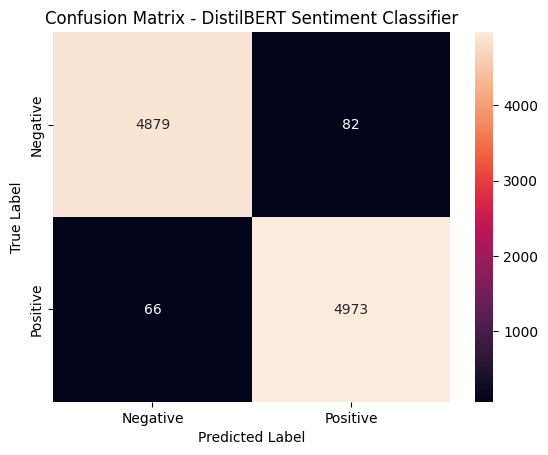

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT Sentiment Classifier")
plt.show()


In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))



Classification Report:

              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      4961
    Positive       0.98      0.99      0.99      5039

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

